In [1]:
using Flux
using Zygote
using Plots

import Pkg
Pkg.status("Flux")

Status `~/.julia/environments/v1.8/Project.toml`
⌅ [587475ba] Flux v0.13.14
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


### <span style="color:orange"> Float32 is important because that is single precision on most GPUs </span>

In [2]:
#generate some target values from this function (non-linear)
function fn1(x)
    if( x < -5 )
        return 1
    elseif( -5 <= x <= 0 )
        return 2
    else 
        return 2x + 2
    end
end

fn1 (generic function with 1 method)

In [3]:
#span a domain to get the training data and then get some random domain points to test on
x_train, x_test = collect(-10:0.1:10), (rand(200) .* 12) .- 10

([-10.0, -9.9, -9.8, -9.7, -9.6, -9.5, -9.4, -9.3, -9.2, -9.1  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], [-5.859152692283606, -4.012936498970448, -9.910714603597416, -3.114143587109849, 1.4099562196690592, -7.55192504491746, -2.9941241603876865, -5.944959450640772, -8.067792930264652, -1.6587745743879054  …  0.22530707388409255, 1.0611538363840864, -0.5796534103818427, -5.536045022659797, 0.08770938116912319, 1.920433780565487, 0.3584935655399697, -2.1702689929880314, 0.8591813272044817, -0.3246825501016257])

In [4]:
y_train, y_test = fn1.(x_train), fn1.(x_test)

(Real[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0], Real[1, 2, 1, 2, 4.819912439338118, 1, 2, 1, 1, 2  …  2.450614147768185, 4.122307672768173, 2, 1, 2.1754187623382464, 5.840867561130974, 2.7169871310799394, 2, 3.7183626544089634, 2])

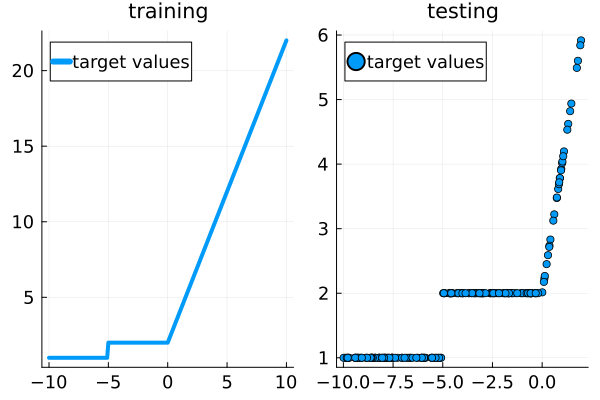

In [5]:
p1 = plot( x_train , y_train , linewidth=4 , title="training" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

In [8]:
#let's make a simple model to predict this data
model = Chain( Dense(1=>20,sigmoid) , Dense(20=>5,relu) , Dense(5=>1) )

Chain(
  Dense(1 => 20, σ),                    # 40 parameters
  Dense(20 => 5, relu),                 # 105 parameters
  Dense(5 => 1),                        # 6 parameters
)                   # Total: 6 arrays, 151 parameters, 988 bytes.

In [9]:
length(model)

3

In [10]:
model[1]

Dense(1 => 20, σ)   # 40 parameters

In [11]:
#look at the weights at initialization
display(model[1].weight)
display(model[2].weight)
display(model[3].weight)

20×1 Matrix{Float32}:
 -0.022602774
 -0.0024618239
 -0.2602612
  0.11011193
  0.1695693
 -0.36513764
  0.3455796
  0.50513154
 -0.42384204
  0.47893834
  0.13272649
 -0.44133648
 -0.098635636
 -0.2769635
 -0.15850157
 -0.2775333
  0.19202214
 -0.09943016
  0.26259628
 -0.3199469

5×20 Matrix{Float32}:
  0.225524   0.225811  -0.373215  …   0.429745   0.125703    -0.256983
  0.410637   0.126341   0.219978      0.127912   0.236728    -0.317367
 -0.106089  -0.104691  -0.44559       0.314243  -0.166194    -0.0499828
 -0.342158  -0.228464  -0.399097      0.337458  -0.00217822   0.329101
  0.182287  -0.342904  -0.315733     -0.216496  -0.114433     0.326423

1×5 Matrix{Float32}:
 0.565492  -0.0285964  0.510836  -0.78331  0.756966

In [12]:
#put the independent samples along the -columns-
init_predictions = model( hcat(x_test...) )

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 20, σ)   # 40 parameters
│   summary(x) = "1×200 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/Nzh8J/src/layers/stateless.jl:50


1×200 Matrix{Float32}:
 0.117304  0.0422963  0.210148  …  -0.0233174  0.0150111  -0.0219145

In [13]:
#get the -initial- loss
#let's use mean absolute error (MAE) here rather than MSE to not focus too much on big values
init_loss = Flux.mae( init_predictions' , y_test )

1.8040657373298914

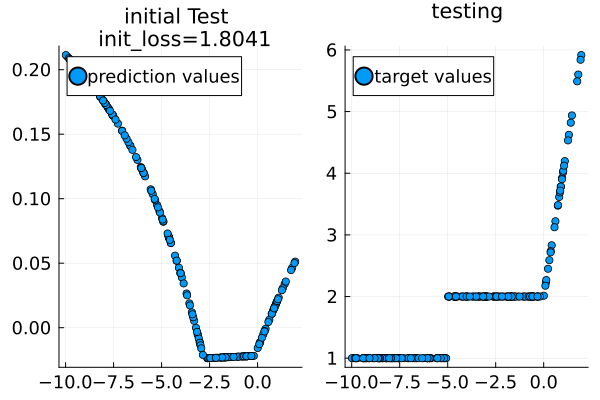

In [14]:
p1 = plot( x_test , init_predictions' , seriestype=:scatter , linewidth=4 , title="initial Test \n init_loss=$(round(init_loss,digits=4))" , 
            label="prediction values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

In [15]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=20, shuffle=true )

11-element DataLoader(::Tuple{Vector{Float64}, Vector{Real}}, shuffle=true, batchsize=20)
  with first element:
  (20-element Vector{Float64}, 20-element Vector{Real},)

In [16]:
opt = Flux.setup( Flux.Adam(0.01) , model )

(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(

In [17]:
#train the parameters
loss( model , x , y ) = Flux.mae( model(hcat(x...))' , y )
for epoch in 1:5000
    
    Flux.train!( loss , model , data , opt )
    
end


In [18]:
last_loss = Flux.mae( model( hcat(x_test...) )' , y_test )

0.0355015570382958

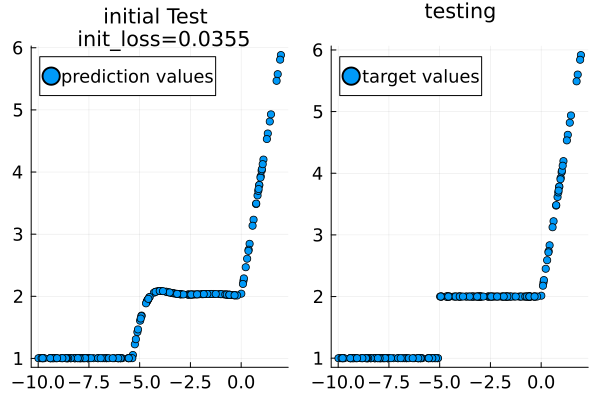

In [19]:
p1 = plot( x_test , model( hcat(x_test...) )' , seriestype=:scatter , linewidth=4 , title="initial Test \n init_loss=$(round(last_loss,digits=4))" , 
            label="prediction values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

### <span style="color:orange"> Let's do some categorical data prediction with the dataset we all are familiar with: **Iris** </span>

There is a nice Julia package to use the plethora of R datasets

In [20]:
using RDatasets

In [21]:
iris = dataset("datasets", "iris")

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [22]:
typeof(iris)

DataFrame

In [23]:
iris = Matrix(iris)
typeof(iris)
display( iris[1:3,:])

3×5 Matrix{Any}:
 5.1  3.5  1.4  0.2  "setosa"
 4.9  3.0  1.4  0.2  "setosa"
 4.7  3.2  1.3  0.2  "setosa"

In [24]:
features = iris[:,1:4]
features = Matrix{Float32}(features) #the numbers need to be in Float32
println( typeof( features ) )
targets = iris[:,5];

Matrix{Float32}


In [25]:
length( unique( iris[:,end] ) )

3

In [26]:
length( iris[:,end] )

150

In [27]:
using StatsBase, Random

In [28]:
# rand_inds = randperm(150)
# train_inds = rand_inds[1:100];
# test_inds = rand_inds[101:end];
odd_inds = findall( mod.(1:150,2) .== 1)
even_inds = findall( mod.(1:150,2) .== 0);

In [29]:
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
println( size(x_train) )
x_train = x_train'
x_test = x_test'
println( size(x_train) )

(75, 4)
(4, 75)


In [30]:
#we need to make 1-hot encoding of the categorical values
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species )

(3, 75)

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [31]:
#make a model for predicting the species (categorical output)
model_iris = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3),                        # 27 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 67 parameters, 524 bytes.

In [33]:
#test the model
println( "model output = " , model_iris( x_train[:,1] ) )
println( "category output predicted ('one-cold') = " , Flux.onecold( model_iris(x_train[:,1]), species ) )
println( "true output label = " , Flux.onecold( y_train[:,1], species ) )
#try out the cross entropy
println( "cross entropy of prediction and target = " , Flux.crossentropy( model_iris( x_train[:,1] ) , y_train[:,1] ) )
println( "cross entropy of predictions and multiple targets = " , Flux.crossentropy( model_iris( x_train[:,1:20] ) , y_train[:,1:20] ) )
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "init accuracy = ", accuracy , "%")

model output = Float32[0.07995729, 0.54683095, 0.3732117]
category output predicted ('one-cold') = versicolor
true output label = setosa
cross entropy of prediction and target = 2.526261
cross entropy of predictions and multiple targets = 2.5211995
init accuracy = 33.333333333333336%


In [34]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );
#data = [(x_train,y_train)]

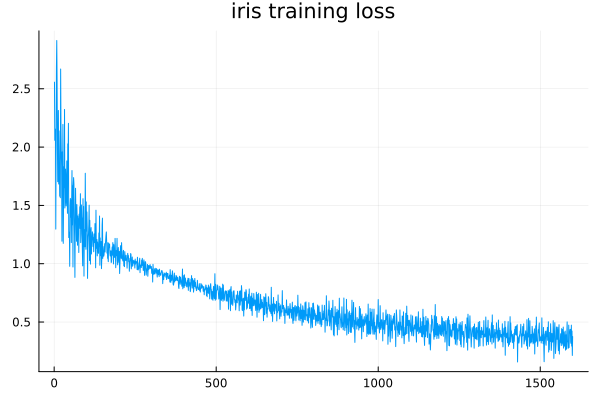

In [35]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_iris );
losses = []
for epoch in 1:200
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_iris, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [36]:
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%")

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%")

Iris train accuracy = 96.0%
Iris test accuracy = 96.0%


In [40]:
fieldnames(typeof(model_iris[1]))

(:weight, :bias, :σ)

In [42]:
model_iris[2].weight

3×8 Matrix{Float32}:
 -0.789153   0.152199  -0.238302   …   0.371916  0.00991581  -0.234335
  0.0393287  0.242368   0.0587313     -0.367039  0.418956    -0.206815
  0.802982   0.482162   0.325798      -0.134427  0.199462     0.418295

In [34]:
# function loss_iris( m , x , y )
#     return Flux.logitcrossentropy( m( x ) , y )
# end
# for epoch in 1:100
#     Flux.train!( loss_iris , model_iris , data , opt )
# end

In [36]:
x = 1
x == nothing

false

### <span style="color:orange"> Instead of using Adam (with momentums) how about doing classic gradient decent with eta ($\eta$) parameter on the gradients for each parameter in the model </span>

Iris train accuracy = 100.0%
Iris test accuracy = 94.66666666666667%


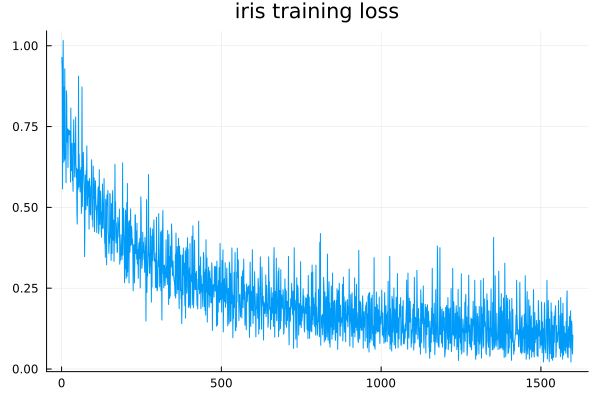

In [38]:
model_iris = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );

# the gradient descent step size
eta = 0.01 
opt = Flux.setup( Flux.Adam(0.001) , model_iris );

losses = []
for epoch in 1:200
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        #Flux.update!(opt, model_iris, grads[1])
        fmap(model_iris, grads[1]) do p, g #custom gradient descent
            if( g != nothing && p != nothing )
                p .= p .- eta .* g
            end
        end
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%")

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%")

p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

### <span style="color:orange"> Now let's try doing some **Regularization** on the parameters of the model to avoid over fitting </span>

In [39]:
using ChainRulesCore

In [40]:
# example of getting the parameters of the model
params = Flux.params(model_iris)
# get the total absolute sum of the model parameters
penalty = sum(sum.(abs,params))
println( penalty )
println( sum(p -> sum(abs, p), params) )

28.1553
28.1553


epoch=1, epoch=2, epoch=3, epoch=4, epoch=5, epoch=6, epoch=7, epoch=8, epoch=9, epoch=10, epoch=11, epoch=12, epoch=13, epoch=14, epoch=15, epoch=16, epoch=17, epoch=18, epoch=19, epoch=20, Iris train accuracy = 86.66666666666667%
Iris test accuracy = 82.66666666666667%
penalty params init = 7.6819954
penalty params final = 7.774535


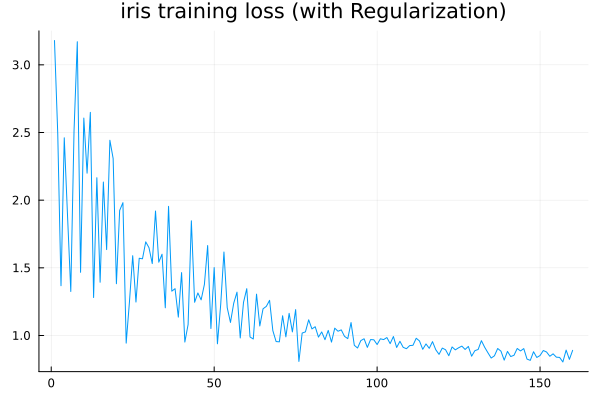

In [41]:
model_iris = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );

opt = Flux.setup( Flux.Adam(0.001) , model_iris );

lambda = 0.5 #for the penalty scaling on the parameters of the model
penalty_init = sum( sum.( abs2 , Flux.params(model_iris) ) )

losses = []
for epoch in 1:20
    for data_tmp in data    
        #get the gradients
        
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            
            y_hat = model(data_tmp[1])
            #get the penalty term and add it to the loss
#             params_tmp = Flux.params(model)
#             penalty = 0
#             ChainRulesCore.ignore_derivatives() do
#                 penalty = sum(p -> sum(abs, p), params) #sum(sum.(abs,params)) #my_penalty(params_tmp) 
#             end
            Flux.crossentropy(y_hat,data_tmp[2]) #.+ lambda*penalty
        end
        Flux.update!(opt, model_iris, grads[1])

        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
    print("epoch=$(epoch), ")
end

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%")

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%")

penalty_final = sum( sum.( abs2 , Flux.params(model_iris) ) )
println( "penalty params init = ", penalty_init )
println( "penalty params final = ", penalty_final )

p1 = plot( losses , title="iris training loss (with Regularization)" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

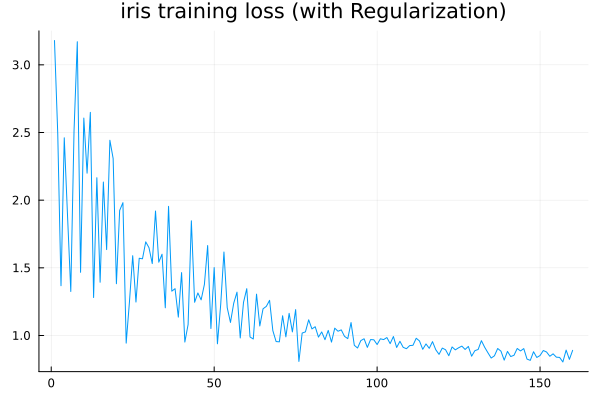

In [42]:
savefig("./p1.png") #save the plot in the current directory
display(p1)

### <span style="color:orange"> Now let's look at the famous Titanic dataset and use features categorical to predict categorical </span>

In [43]:
titanic = dataset("datasets", "Titanic")

Row,Class,Sex,Age,Survived,Freq
,String7,String7,String7,String3,Int64
1,1st,Male,Child,No,0
2,2nd,Male,Child,No,0
3,3rd,Male,Child,No,35
4,Crew,Male,Child,No,0
5,1st,Female,Child,No,0
6,2nd,Female,Child,No,0
7,3rd,Female,Child,No,17
8,Crew,Female,Child,No,0
9,1st,Male,Adult,No,118


In [44]:
size( titanic )

(32, 5)

In [45]:
#titanic = Matrix(titanic)
features = Array{String}(titanic[:,1:3])
targets = Array{String}(titanic[:,4])
println( size(features) )

(32, 3)


In [46]:
targets

32-element Vector{String}:
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 ⋮
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"

In [47]:
features

32×3 Matrix{String}:
 "1st"   "Male"    "Child"
 "2nd"   "Male"    "Child"
 "3rd"   "Male"    "Child"
 "Crew"  "Male"    "Child"
 "1st"   "Female"  "Child"
 "2nd"   "Female"  "Child"
 "3rd"   "Female"  "Child"
 "Crew"  "Female"  "Child"
 "1st"   "Male"    "Adult"
 "2nd"   "Male"    "Adult"
 "3rd"   "Male"    "Adult"
 "Crew"  "Male"    "Adult"
 "1st"   "Female"  "Adult"
 ⋮                 
 "1st"   "Female"  "Child"
 "2nd"   "Female"  "Child"
 "3rd"   "Female"  "Child"
 "Crew"  "Female"  "Child"
 "1st"   "Male"    "Adult"
 "2nd"   "Male"    "Adult"
 "3rd"   "Male"    "Adult"
 "Crew"  "Male"    "Adult"
 "1st"   "Female"  "Adult"
 "2nd"   "Female"  "Adult"
 "3rd"   "Female"  "Adult"
 "Crew"  "Female"  "Adult"

In [56]:
rand_inds = randperm(32)
train_inds = rand_inds[1:28]
test_inds = rand_inds[20:end];

In [57]:
x_train , x_test = features[train_inds,:] , features[test_inds,:];
y_train , y_test = targets[train_inds] , targets[test_inds];
println( size(x_train) )


(28, 3)


In [58]:
#place the features in 1-hot encoding where each categorical variable itself needs its own encoding and then concatenation of each variable together
col1_unique = unique(features[:,1])
col2_unique = unique(features[:,2])
col3_unique = unique(features[:,3])

function features_OneHot(features)
    features_1hot = []
    for row in eachrow(features)
        sample_1hot = []
        for (index,col) in enumerate(row)
            if( index == 1 )
                push!( sample_1hot , Flux.onehot( col , col1_unique )... )
            elseif( index == 2 )
                push!( sample_1hot , Flux.onehot( col , col2_unique )... )
            else
                push!( sample_1hot , Flux.onehot( col , col3_unique )... )
            end        
        end
        if( size(features_1hot) != (0,) )
            features_1hot = [features_1hot  sample_1hot ]
        else
            features_1hot = sample_1hot
        end
    end
    return features_1hot
end

x_train = Array{Float32}(features_OneHot(x_train))
x_test = Array{Float32}(features_OneHot(x_test))

8×13 Matrix{Float32}:
 1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0

In [59]:
function target_OneHot(targets)
    targets_new = zeros(size(targets)[1])
    yes_inds = findall(targets .== "Yes")
    targets_new[yes_inds] .= 1
    return targets_new
end
y_train = Array{Float32}(target_OneHot(y_train)')
y_test = Array{Float32}(target_OneHot(y_test)')

1×13 Matrix{Float32}:
 0.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0

In [60]:
#make a model for predicting the survived (categorical output)
model_titanic = Chain( Dense(8=>20,sigmoid),Dense(20=>10,relu),Dense(10=>1,sigmoid) )

Chain(
  Dense(8 => 20, σ),                    # 180 parameters
  Dense(20 => 10, relu),                # 210 parameters
  Dense(10 => 1, σ),                    # 11 parameters
)                   # Total: 6 arrays, 401 parameters, 1.941 KiB.

In [61]:
println( "sample model output = " , model_titanic( x_train[:,1] ) )
println( "sample binary cross entropy loss = " , Flux.binarycrossentropy(model_titanic(x_train[:,1]),y_train[1])  )

sample model output = Float32[0.49983877]
sample binary cross entropy loss = 0.69346946


In [62]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=2 , shuffle=true );

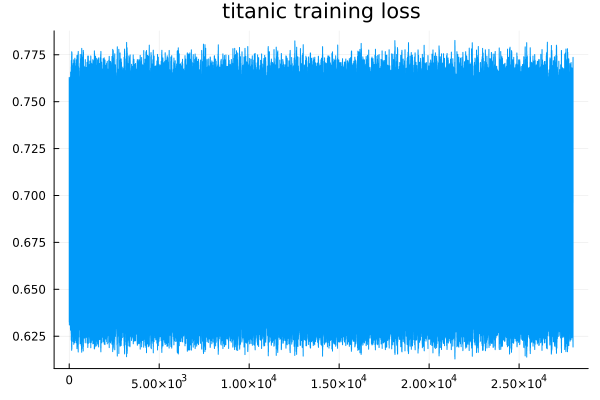

In [78]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.01) , model_titanic );
losses = []
for epoch in 1:2000
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_titanic) do model
            y_hat = model(data_tmp[1])
            Flux.binarycrossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_titanic, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="titanic training loss" , legend=false )
savefig("./p1.png") #save the plot in the current directory
display(p1)

In [79]:
mean( round.( model_titanic(x_train) ) .== y_train )

0.5357142857142857

In [80]:
mean( round.( model_titanic(x_test) ) .== y_test )

0.38461538461538464

### <span style="color:orange"> Let's try a dataset for titanic with more observations </span>

In [81]:
using CSV, DataFrames

In [82]:
titanic_data = CSV.File(open("./data/titanic.csv")) |> DataFrame;

In [83]:
size( titanic_data )

(891, 12)

In [84]:
#drop rows that are containing a missing element
titanic_data = titanic_data[completecases(titanic_data), :];

In [85]:
size( titanic_data )

(183, 12)

In [86]:
titanic_data[1:3,:]

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64?,Int64,Int64,String31,Float64,String15?,String1?
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
3,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [87]:
names(titanic_data) #just like in R

12-element Vector{String}:
 "PassengerId"
 "Survived"
 "Pclass"
 "Name"
 "Sex"
 "Age"
 "SibSp"
 "Parch"
 "Ticket"
 "Fare"
 "Cabin"
 "Embarked"

In [88]:
#predict survived, binary target
targets = Array{Float32}(titanic_data[:,:Survived])'
println( targets[1:10] )

Float32[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]


In [89]:
#use a mix of numerical and categorical as features
features_numerical = Matrix{Float32}( titanic_data[:,[:Pclass,:Age,:Fare]] );
#encode the 'female' as 1 and the 'male' as 0
features_categorical = Array{Float32}( [titanic_data[rr,:Sex] == "female" ? 1 : 0 for rr in 1:nrow(titanic_data)] )
features = hcat( features_numerical , features_categorical )'

4×183 adjoint(::Matrix{Float32}) with eltype Float32:
  1.0      1.0   1.0      3.0   1.0   …   1.0      1.0   1.0      1.0   1.0
 38.0     35.0  54.0      4.0  58.0      47.0     33.0  56.0     19.0  26.0
 71.2833  53.1  51.8625  16.7  26.55     52.5542   5.0  83.1583  30.0  30.0
  1.0      1.0   0.0      1.0   1.0       1.0      0.0   1.0      1.0   0.0

In [90]:
rand_inds = randperm( size(titanic_data)[1] )
train_inds = rand_inds[ 1 : Int(round(0.65*size(titanic_data)[1])) ]
test_inds = rand_inds[ 1 : Int(round(0.35*size(titanic_data)[1])) ];

In [91]:
x_train , x_test = features[:,train_inds] , features[:,test_inds];
y_train , y_test = Array{Float32}(targets[train_inds])' , Array{Float32}(targets[test_inds]');
println( size(y_train) )

(1, 119)


In [92]:
#make a model for predicting the survived (categorical output)
model_titanic = Chain( Dense(4=>8,relu),Dense(8=>3,relu),Dense(3=>1,sigmoid) )

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3, relu),                  # 27 parameters
  Dense(3 => 1, σ),                     # 4 parameters
)                   # Total: 6 arrays, 71 parameters, 668 bytes.

In [93]:
println( "sample model output = " , model_titanic( x_train[:,1] ) )
println( "sample binary cross entropy loss = " , Flux.binarycrossentropy(model_titanic(x_train[:,1]),y_train[1]) )
println( "multiple model output = " , model_titanic( x_train[:,1:3] ) )
println("multiple binary cross entropy loss=",Flux.binarycrossentropy(model_titanic(x_train[:,1:3])',y_train[1,1:3]))

sample model output = Float32[0.9162794]
sample binary cross entropy loss = 0.08743384
multiple model output = Float32[0.9162794 0.0 0.9119173]
multiple binary cross entropy loss=5.374008


In [94]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=4 , shuffle=true );

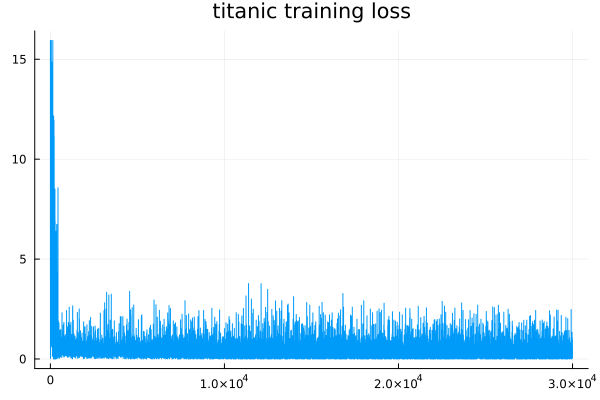

In [95]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_titanic );
losses = []
for epoch in 1:1000
    for data_tmp in data   
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_titanic) do model
            y_hat = model(data_tmp[1])
            Flux.binarycrossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_titanic, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="titanic training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [96]:
println( "accuracy on training = " , 100 * mean( round.( model_titanic(x_train) ) .== y_train ) )

accuracy on training = 83.19327731092437


In [97]:
println( "accuracy on testing = " , 100 * mean( round.( model_titanic(x_test) ) .== y_test ) )

accuracy on testing = 81.25


### <span style="color:orange"> Let's log and visualize the changes to a single selected parameter weight value, eg layer 2, weight (2,1), and the **loss** in respect to it </span>

the gradient as choosing $\frac{ \partial f }{ \partial \theta_{2,2,3} } $ , partial derivative of the loss with respect layer 2, weight 2,1

In [98]:
#make a model for predicting the survived (categorical output)
model_titanic = Chain( Dense(4=>8,relu),Dense(8=>3,relu),Dense(3=>1,sigmoid) )

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3, relu),                  # 27 parameters
  Dense(3 => 1, σ),                     # 4 parameters
)                   # Total: 6 arrays, 71 parameters, 668 bytes.

In [99]:
#layer 2, weight 2,1
weight_val = model_titanic.layers[1].weight[2,1]

-0.27382326f0

In [100]:
#partial derivative of the loss with respect layer 2, weight 2,1
grads = Flux.gradient(m -> Flux.binarycrossentropy(m(x_train[:,1]), y_train[1]), model_titanic)
grads[1].layers[1].weight[2,1]

0.0f0

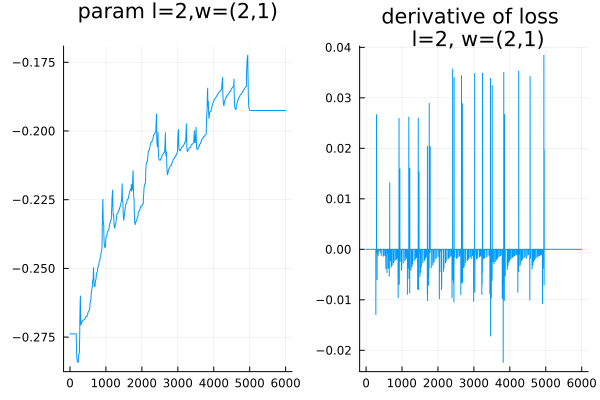

In [101]:
#train the parameters to predict iris

#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=4 , shuffle=true );
opt = Flux.setup( Flux.Adam(0.001) , model_titanic );
weight_vals = []
derivative_vals = []
for epoch in 1:200
    for data_tmp in data   
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_titanic) do model
            y_hat = model(data_tmp[1])
            Flux.binarycrossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_titanic, grads[1])
        weight_val = model_titanic.layers[1].weight[2,1]
        push!(weight_vals,weight_val) #don't put this in the above block where the gradient is computed
        derivative_val = grads[1].layers[1].weight[2,1]
        push!(derivative_vals,derivative_val)
    end
end
p1 = plot( weight_vals , title="param l=2,w=(2,1)" , legend=false )
p2 = plot( derivative_vals , title="derivative of loss \n l=2, w=(2,1)" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
plot(p1,p2)

### <span style="color:orange"> Freezing / Scheduling / Altering the parameter training (optimizations) </span>

- As we saw, we can provide a step size to Adam (or the eta parameter) for the step on the gradient to take on changing the parameters. The larger the value the bigger the steps, and it makes sense to have bigger values at the start of the scheme (early on epochs) and then to reduce the size (later on epochs) to focus on the areas it finds and not 'jump' around the minimum found
- Then we also want to be able to **freeze** (hold, fix, constrain) a subset of the parameters at a value and then have the rest be optimized. This is especially relevant for applications with models built upon an **encoder** and **decoder**.

In [71]:
#let us use iris again

features = iris[:,1:4]
features = Matrix{Float32}(features) #the numbers need to be in Float32
println( typeof( features ) )
targets = iris[:,5];
odd_inds = findall( mod.(1:150,2) .== 1)
even_inds = findall( mod.(1:150,2) .== 0);
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
x_train = x_train'
x_test = x_test'
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species );
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );

Matrix{Float32}


(3, 75)

In [72]:
#now make 3 models for the different training schemes
model_iris_fixed_High = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)
model_iris_fixed_Low = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)
model_iris_Scheduled = Chain(Dense(4=>8,relu),Dense(8=>3),softmax);

In [73]:
high_step = 0.1
low_step = 0.0005

0.0005

In [74]:
opt_high = Flux.setup( Flux.Adam(high_step) , model_iris_fixed_High );
opt_low = Flux.setup( Flux.Adam(low_step) , model_iris_fixed_Low );
opt_scheduled = Flux.setup( Flux.Adam(high_step) , model_iris_Scheduled );

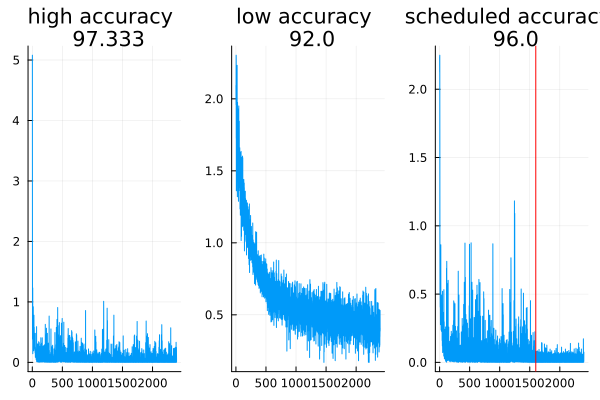

In [75]:

#train the parameters to predict iris with 3 schemes, fixed at a high step, fixed at low step, high to low values
losses_high = []
losses_low = []
losses_scheduled = []
for epoch in 1:300
    for data_tmp in data    
        
        #high
        loss_tmp, grads = Flux.withgradient(model_iris_fixed_High) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt_high, model_iris_fixed_High, grads[1])
        push!(losses_high,loss_tmp) #don't put this in the above block where the gradient is computed
        
        #low
        loss_tmp, grads = Flux.withgradient(model_iris_fixed_Low) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt_low, model_iris_fixed_Low, grads[1])
        push!(losses_low,loss_tmp) #don't put this in the above block where the gradient is computed

        #scheduled
        if( epoch == 200 ) Flux.adjust!( opt_scheduled , low_step ) end
        loss_tmp, grads = Flux.withgradient(model_iris_Scheduled) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt_scheduled, model_iris_Scheduled, grads[1])
        push!(losses_scheduled,loss_tmp) #don't put this in the above block where the gradient is computed
        
        
    end
end

hits = Flux.onecold( model_iris_fixed_High( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy_high = 100 * sum( hits ) / length( hits )
hits = Flux.onecold( model_iris_fixed_Low( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy_low = 100 * sum( hits ) / length( hits )
hits = Flux.onecold( model_iris_Scheduled( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy_scheduled = 100 * sum( hits ) / length( hits )

p1 = plot( losses_high , title="high accuracy \n $(round(accuracy_high,digits=3))" , legend=false )
p2 = plot( losses_low , title="low accuracy \n $(round(accuracy_low,digits=3))" , legend=false )
p3 = plot( losses_scheduled , title="scheduled accuracy \n $(round(accuracy_scheduled,digits=3))" , legend=false )
plot!([round(length(losses_scheduled)*(200/300))], seriestype="vline", color="red")

plot(p1,p2,p3,layout=grid(1,3))

### <span style="color:orange"> Different learning rates for different parts of the **same** model </span>

- we may want to set the learning rate for a part of the model to be different to the learning rate of the other part of a model
- a common place for this is with the encoder - decoder architecture (the representation is compressed and then extrapolated)
- we used **Flux.adjust!** to change the eta param value in the optimizer, but we can use **Flux.adjust!** to change it for a component within the same model

In [76]:
function data_Pnt_Rnd()
    train_dim = 10
    test_dim = 4
    train_pnt = round.(Float32.( rand(train_dim)) ) # random 1s0s in Float32
    if( sum(train_pnt) <= 5 )
        test_pnt = Float32.( zeros( test_dim ) )
    elseif( sum(train_pnt) > 5 )
        test_pnt = Float32.( ones( test_dim ) )
    end
    return (train_pnt,test_pnt) #testing data is all 1s or 0s depending upon the aggregate value of the training data
end
#generate the data
NN = 100
x_train , y_train = data_Pnt_Rnd()
foreach(1:NN-1) do ii 
    tmp = data_Pnt_Rnd()
    global x_train = hcat(x_train,tmp[1])
    global y_train = hcat(y_train,tmp[2])
end
println( size(x_train) )
println( size(y_train) )

(10, 100)
(4, 100)


In [78]:
encoder1 = Chain( Dense(10=>5,relu) , Dense(5=>1,sigmoid) )
decoder1 = Chain( Dense(1=>4) )
auto_enc1 = Chain( encoder = encoder1 , decoder = decoder1 )

Chain(
  encoder = Chain(
    Dense(10 => 5, relu),               # 55 parameters
    Dense(5 => 1, σ),                   # 6 parameters
  ),
  decoder = Chain(
    Dense(1 => 4),                      # 8 parameters
  ),
)                   # Total: 6 arrays, 69 parameters, 756 bytes.

In [80]:
#test model
println( auto_enc1( data_Pnt_Rnd()[1] ) )

Float32[0.20375457, 0.41806352, 0.07073254, 0.14975786]


In [81]:
#get the encoder and decoder components
println( auto_enc1.layers.encoder )
println( auto_enc1.layers.decoder )

Chain(Dense(10 => 5, relu), Dense(5 => 1, σ))
Chain(Dense(1 => 4))


In [82]:
#change the learning rate for the encoder after the value for the whole model
opt = Flux.setup( Flux.Adam(0.05) , auto_enc1 );
Flux.adjust!( opt.layers.encoder , 0.005 ) #change from the eta for the encoder named here learns at a different rate

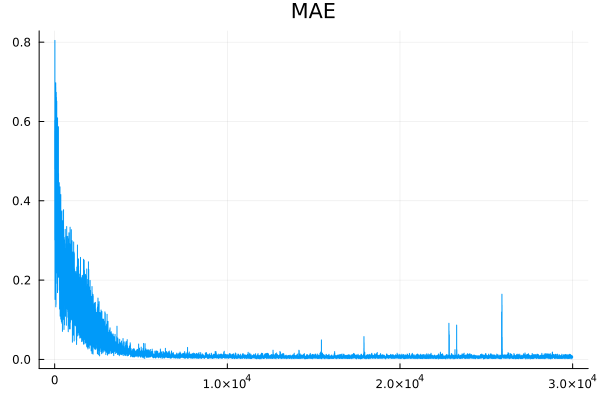

In [83]:
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );
losses = []
for epoch in 1:3000
    for data_tmp in data   
        #get the gradients
        loss_tmp, grads = Flux.withgradient(auto_enc1) do model
            y_hat = model(data_tmp[1])
            Flux.mae(y_hat,data_tmp[2])
        end
        Flux.update!(opt, auto_enc1, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="MAE" , legend=false )
display( p1 )

In [84]:
#random full inputs to outputs, training to testing
[ auto_enc1( data_Pnt_Rnd()[1] ) for _ in 1:10 ]

10-element Vector{Vector{Float32}}:
 [-0.0044831634, 0.01674968, 6.067753f-5, -0.012782395]
 [-0.0004324913, 0.020803869, 0.004142523, -0.008684218]
 [-0.0004324913, 0.020803869, 0.004142523, -0.008684218]
 [-0.0004324913, 0.020803869, 0.004142523, -0.008684218]
 [-0.0004324913, 0.020803869, 0.004142523, -0.008684218]
 [-0.0004324913, 0.020803869, 0.004142523, -0.008684218]
 [-0.0004324913, 0.020803869, 0.004142523, -0.008684218]
 [0.99454314, 1.0166495, 1.006781, 0.9979531]
 [0.99454314, 1.0166495, 1.006781, 0.9979531]
 [-0.0004324913, 0.020803869, 0.004142523, -0.008684218]

In [85]:
#random encodings from inputs of training
[ auto_enc1.layers.encoder( data_Pnt_Rnd()[1] ) for _ in 1:10 ]

10-element Vector{Vector{Float32}}:
 [7.768812f-6]
 [8.591819f-5]
 [0.29838744]
 [0.29838744]
 [0.29838744]
 [0.29838744]
 [2.5916762f-15]
 [1.2174186f-9]
 [4.1951207f-5]
 [0.29838744]

In [86]:
#random encodings to testings
display( auto_enc1.layers.decoder( [0] ) )
display( auto_enc1.layers.decoder( [1] ) )
encodings_tmp = round.( rand(10) )
println( encodings_tmp )
[ auto_enc1.layers.decoder( [encodings_tmp[ii]] ) for ii in 1:10 ]

4-element Vector{Float32}:
 0.99454314
 1.0166495
 1.006781
 0.9979531

4-element Vector{Float32}:
 -2.339966
 -2.3207753
 -2.3534088
 -2.3756385

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]


10-element Vector{Vector{Float64}}:
 [0.9945431351661682, 1.0166494846343994, 1.006780982017517, 0.9979531168937683]
 [0.9945431351661682, 1.0166494846343994, 1.006780982017517, 0.9979531168937683]
 [0.9945431351661682, 1.0166494846343994, 1.006780982017517, 0.9979531168937683]
 [0.9945431351661682, 1.0166494846343994, 1.006780982017517, 0.9979531168937683]
 [0.9945431351661682, 1.0166494846343994, 1.006780982017517, 0.9979531168937683]
 [-2.3399659991264343, -2.320775270462036, -2.353408932685852, -2.3756385445594788]
 [-2.3399659991264343, -2.320775270462036, -2.353408932685852, -2.3756385445594788]
 [0.9945431351661682, 1.0166494846343994, 1.006780982017517, 0.9979531168937683]
 [0.9945431351661682, 1.0166494846343994, 1.006780982017517, 0.9979531168937683]
 [-2.3399659991264343, -2.320775270462036, -2.353408932685852, -2.3756385445594788]

### <span style="color:orange"> **freeze!** and **thaw!** to fix / constrain parameters at a value so optimization does not change their values and then allow their changes again </span>

- **thaw!** unfreezes all the parameters in the model that can also be freezed again later
- **freeze!** is typically used on one or more of the named layers of the model chain
- personally I would prefer the terms, 'hold' and 'release' but the heat temperature analogy stems from the 1-hot encoding paradigm

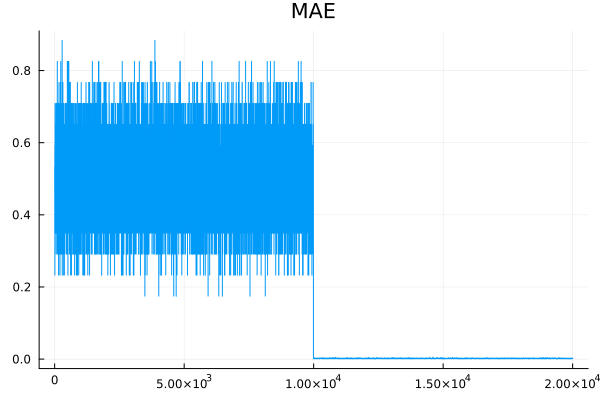

10-element Vector{Vector{Float32}}:
 [0.559738]
 [1.1341042f-15]
 [1.6892861f-10]
 [0.582422]
 [0.5808806]
 [2.0565934f-10]
 [0.582422]
 [0.582422]
 [0.582422]
 [3.3956227f-10]

In [184]:

encoder2 = Chain( Dense(10=>5,relu) , Dense(5=>1,sigmoid) )
decoder2 = Chain( Dense(1=>4) )
auto_enc2 = Chain( encoder = encoder1 , decoder = decoder1 )
opt = Flux.setup( Flux.Adam(0.01) , auto_enc2 ); #single rate this time
Flux.freeze!( opt.layers.decoder ) #start off freezing the params of the decoder

data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true )
losses = []
for epoch in 1:2000
    for data_tmp in data   
        
        if( epoch == 1000) 
            Flux.thaw!(opt) #Flux.thaw! un-freezes the entire model
            Flux.freeze!( opt.layers.encoder )
        end
        
        loss_tmp, grads = Flux.withgradient(auto_enc2) do model
            if( epoch < 1000 )
                enc_tmp = auto_enc2.layers.encoder( data_tmp[1] )
                Flux.mae( enc_tmp , data_tmp[2][1] ) #is the representation of the compression equal to the first element of the target?
            else
                y_hat = model(data_tmp[1])
                Flux.mae(y_hat,data_tmp[2])
            end            
        end
        
        Flux.update!(opt, auto_enc2, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="MAE" , legend=false )
display( p1 )

[ auto_enc2.layers.encoder( data_Pnt_Rnd()[1] ) for _ in 1:10 ]

In [185]:
display( auto_enc2.layers.decoder( [0] ) )
display( auto_enc2.layers.decoder( [1] ) )
encodings_tmp = round.( rand(10) )
println( encodings_tmp )
[ auto_enc2.layers.decoder( [encodings_tmp[ii]] ) for ii in 1:10 ]

4-element Vector{Float32}:
 0.99981326
 0.9988128
 0.9983849
 1.0004117

4-element Vector{Float32}:
 -0.7162699
 -0.72112954
 -0.7166862
 -0.7183229

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]


10-element Vector{Vector{Float64}}:
 [0.9998132586479187, 0.9988127946853638, 0.9983848929405212, 1.0004117488861084]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]
 [0.9998132586479187, 0.9988127946853638, 0.9983848929405212, 1.0004117488861084]
 [-0.7162699103355408, -0.7211295366287231, -0.7166861891746521, -0.7183228731155396]

In [93]:
### <span style="color:orange"> Freezing / Scheduling / Altering the parameter training (optimizations) </span>